# 1. Instalación e importación de bibliotecas

In [ ]:
!git clone https://github.com/angelfergar/ChurnRetention-SP.git

Cloning into 'ChurnRetention-SP'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 100 (delta 41), reused 33 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 3.39 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorIndexer,VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier as DTSpark
from pyspark.ml.classification import RandomForestClassifier as RFSpark
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import requests
import joblib

In [ ]:
dataset_path = '/content/ChurnRetention-SP/data/preprocessed_customerChurn.csv'
df = pd.read_csv(dataset_path)

# 2. Equilibrado de datos

Creamos los dataset que usaremos para el entrenamiento de los modelos

In [ ]:
df_X = df.drop('Churn Label', axis=1)
df_y = df['Churn Label']

In [ ]:
features = df_X.columns.tolist()
label = 'Churn Label'

spark_x = df[features]
spark_y = df[label]

Aumentamos de forma sintética la clase minoritaria un 65% y reduce la clase mayoritaria en un 25% (Se llega a estas cifras a base de prueba y error). De esta forma, pasamos de tener una proporción de 3:1 a una de 1.25 sin introducir un exceso de ruido que pueda provocar overfitting en el modelo ni perder una gran cantidad de datos.

In [ ]:
smote = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.8)

# Creamos un pipeline para aplicar ambas técnicas a la vez
pipeline = Pipeline([('smote', smote), ('under', under)])

# Obtenemos dos nuevos datasets con los datos equilibrados
X_resampled, y_resampled = pipeline.fit_resample(spark_x, spark_y)

# Creamos el dataframe que pasaremos a Spark
df_spark = pd.DataFrame(X_resampled, columns=features)
df_spark[label] = y_resampled

# 3. Preparación de Spark

Lo primero que haremos para trabajar con Spark es iniciar una sesión.

In [ ]:
spark = SparkSession.builder.appName('ChurnRetention-SP').getOrCreate()

spark_df = spark.createDataFrame(df_spark)

A continuación, transformamos los datos en un formato que sea compatible para Spark. Se necesitan que las columnas estén en una única columna de tipo Vector.

In [ ]:
feature_columns = [col for col in df_spark.columns if col != 'Churn Label']
label_column = 'Churn Label'

# Ponemos las features en un solo vector para que puedan ser usadas por modelos de ML de Spark
assembler = VectorAssembler(inputCols=feature_columns, outputCol='rawFeatures')
spark_df = assembler.transform(spark_df)

feature_indexer = VectorIndexer(inputCol='rawFeatures', outputCol='features')
spark_df = feature_indexer.fit(spark_df).transform(spark_df)

# Convertimos la label en índices numéricos para su uso en el modelo de Spark
label_indexer = StringIndexer(inputCol=label_column, outputCol='indexedLabel')
spark_df = label_indexer.fit(spark_df).transform(spark_df)

El último paso previo al entrenamiento de los modelos es obtener los dataFrames de test y train.

In [ ]:
train_df, test_df = spark_df.randomSplit([0.7, 0.3])

# 4. Entrenamiento de los modelos

En este apartado vamos a trabajar con tres de los modelos incluídos en la librería de MLlib de Spark: **Decision Tree, Random Forest y GBTClassifier**.

Al ser una introducción al escalado a Spark del proyecto realizado, no entraremos tan en detalle en las métricas como en el notebook de ML estándar. Aún así, es importante mencionar que nos centraremos en la métrica del **F1-Score**, tal como se hizo en el notebook de Model_Training. Esto se debe a que contamos con un dataset desequilibrado, y al haber aplicado técnicas de equilibrado.

También usaremos la **Matriz de Confusión**, **AUC ROC** y **Precision-Recall** para sacar más información sobre cada uno de los modelos, así como la **importancia de las features** a la hora de determinar las clases.

Finalmente, aplicaremos métodos de **fine tuning** propios de Spark para incrementar la efectividad del mejor modelo entrenado.

Crearemos una serie de funciones para poder reutilizar código y mostrar más fácilmente todo el reporte de cada uno de los modelos. El primer paso será entrenar el modelo y mostrar las features que más impactan a la hora de predecir el Churn

In [ ]:
# Con esta función entrenamos el modelo y obtenemos predicciones
def train_model(model_type, train_df, test_df):
    model = model_type.fit(train_df)
    pred = model.transform(test_df)
    return model, pred

In [ ]:
# Obtenemos la importancia de las diferentes features
def importance_features(model, feature_columns):
    feature_importance = model.featureImportances
    # Coleccionamos las features y las ordenamos
    feature_importance_dict = {feature: importance for feature, importance in zip(feature_columns, feature_importance)}
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Mostramos las 10 features más importantes
    print('Feature más importantes:')
    for feature, importance in sorted_features[:10]:
        print(f'{feature}: {importance:.4f}')

Las siguientes funciones se usarán para mostrar información sobre las métricas. Obtenemos Precision, Recall, F1-Score, y AUC ROC y AUC Precision-Recall

In [ ]:
def get_metrics(predictions, label_col='indexedLabel'):

    # Creamos un diccionario donde guardaremos las métricas para mostrarlas en gráficos posteriormente
    metrics = {'precision_majority': [], 'precision_minority': [],
               'recall_majority': [], 'recall_minority': [], 'f1_score': []}

    # Preparamos los evaluadores de cada una de las métricas (Precision, Recall, F1-Score)
    precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='precisionByLabel')
    recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='recallByLabel')
    f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='f1')

    # En este caso tenemos que dividir precision y recall en dos, ya que se nos dan los valores para ambas clases originalmente
    precision_0 = precision_evaluator.evaluate(predictions, {precision_evaluator.metricLabel: 0})
    precision_1 = precision_evaluator.evaluate(predictions, {precision_evaluator.metricLabel: 1})
    recall_0 = recall_evaluator.evaluate(predictions, {recall_evaluator.metricLabel: 0})
    recall_1 = recall_evaluator.evaluate(predictions, {recall_evaluator.metricLabel: 1})
    f1_score = f1_evaluator.evaluate(predictions)

    print(f'''
        Precision Retained: {precision_0:.2f}\n
        Precision Churned: {precision_1:.2f}\n
        Recall Retained: {recall_0:.2f}\n
        Recall Churned: {recall_1:.2f}\n
        F1 Score: {f1_score:.2f}'''
    )

    # Guardamos los resultados en el diccionario
    metrics['precision_majority'].append(precision_0)
    metrics['precision_minority'].append(precision_1)
    metrics['recall_majority'].append(recall_0)
    metrics['recall_minority'].append(recall_1)
    metrics['f1_score'].append(f1_score)

    return metrics

In [ ]:
def auc_metrics(predictions, label_col='indexedLabel'):
    # Configuramos los evaluadores del AUC ROC y AUC Precision-Recall
    auc_evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName='areaUnderROC')
    auc_pr_evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName='areaUnderPR')

    auc_roc = auc_evaluator.evaluate(predictions)
    auc_pr = auc_pr_evaluator.evaluate(predictions)

    print(f'''
        AUC ROC:  {auc_roc}\n
        AUC Precision-Recall: {auc_pr}'''
    )

    return auc_roc, auc_pr

Y finalmente, preparamos la función que usaremos para mostrar la matriz de confusión

In [ ]:
def show_conf_matrix(predictions):
  predictions_pd = predictions.select('prediction', 'indexedLabel').toPandas()

  x_true = predictions_pd['indexedLabel'].values
  y_pred = predictions_pd['prediction'].values

  conf_matrix_rf_s = confusion_matrix(x_true, y_pred)

  plt.figure(figsize=(12, 6))
  sns.heatmap(conf_matrix_rf_s, annot=True, fmt='d', cmap='Greens', xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned']);
  plt.ylabel('Etiquetas Verdaderas')
  plt.xlabel('Predicciones')
  plt.title('Matriz de Confusión - Spark')
  plt.show()

Con todas estas funciones obtendremos un reporte completo sobre cada uno de los modelos que contenga:

* **Entrenar un modelo**
* **Obtener las features que más peso tienen a la hora de predecir el Churn**
* **Mostrar la Matriz de Confusión**
* **Obtener las métricas de AUC de ROC y Precision-Recall Curve**

In [ ]:
# Establecemos los parámetros para los modelos
dt_model = DTSpark(labelCol='indexedLabel', featuresCol='features',  maxDepth = 15, minInstancesPerNode=1, maxBins = 16, minInfoGain = 0.01) # Decision Tree
rf_model = RFSpark(labelCol='indexedLabel', featuresCol='features',  numTrees = 100, maxDepth = 15, minInstancesPerNode=1, maxBins = 16, minInfoGain = 0.01,
                   featureSubsetStrategy = 'sqrt') # Random Forest
gbt_model = GBTClassifier(labelCol='indexedLabel', featuresCol='features', maxIter=30, maxDepth = 5, minInstancesPerNode = 10, minInfoGain = 0.0, maxBins = 8,
                          subsamplingRate= 0.95) # GBT Classifier

## 4.1 Decision Tree

El primer modelo que desarrollaremos es el de Decision Tree. Se usará como baseline para comparar con el resto de modelos, identificar posibles puntos de mejora general.

### 4.1.1 Entrenamiento y feature_importance

In [ ]:
# Entrenamos el modelo y obtenemos predicciones
model_dt, predictions_dt = train_model(dt_model, train_df, test_df)

In [ ]:
# Obtenemos las métricas de Precision, Recall y F1-Score
metrics_dt = get_metrics(predictions_dt)


        Precision Retained: 0.86

        Precision Churned: 0.72

        Recall Retained: 0.71

        Recall Churned: 0.87

        F1 Score: 0.78


In [ ]:
# Mostramos en orden las features más importantes
importance_features(model_dt, feature_columns)

Feature más importantes:
Contract_Two year: 0.2391
Contract_One year: 0.1668
Tenure Months: 0.1080
Dependents: 0.1064
Internet Service_Fiber optic: 0.0598
Monthly Charges: 0.0580
Partner: 0.0236
Total Charges: 0.0230
Streaming Movies_Yes: 0.0226
Payment Method_Electronic check: 0.0224


### 4.1.2 Matriz de confusión

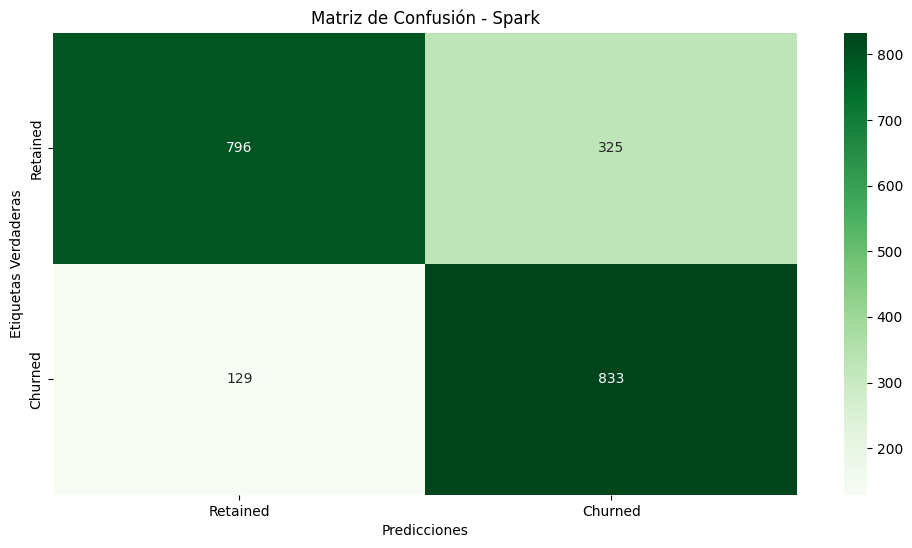

In [ ]:
show_conf_matrix(predictions_dt)

### 4.1.3 AUC ROC y Precision-Recall

In [ ]:
dt_roc, dt_pr = auc_metrics(predictions_dt)


        AUC ROC:  0.7620507009445456

        AUC Precision-Recall: 0.7427875107018552


### 4.1.4 Conclusiones finales

Las métricas obtenidas con **el modelo de Decision Tree de Spark nos muestran una mejora general** con respecto a los modelos de Machine Learning estándar. Esto nos permite ser más efectivos a la hora de identificar los clientes que se dan de baja.

Podemos ver esta **mejora en la Precisio y Recall de la clase minoritaria y el AUC de la curva Precision-Recall**.

## 4.2 Random Forest

### 4.2.1 Entrenamiento y feature_importance

In [ ]:
# Entrenamos el modelo y obtenemos predicciones
model_rf, predictions_rf = train_model(rf_model, train_df, test_df)

In [ ]:
# Obtenemos las métricas de Precision, Recall y F1-Score
metrics_rf = get_metrics(predictions_rf)


        Precision Retained: 0.82

        Precision Churned: 0.77

        Recall Retained: 0.80

        Recall Churned: 0.79

        F1 Score: 0.80


In [ ]:
# Mostramos en orden las features más importantes
importance_features(model_rf, feature_columns)

Feature más importantes:
Tenure Months: 0.1562
Contract_Two year: 0.1241
Dependents: 0.0944
Internet Service_Fiber optic: 0.0923
Total Charges: 0.0730
Payment Method_Electronic check: 0.0598
Contract_One year: 0.0545
Online Security_Yes: 0.0476
Monthly Charges: 0.0445
Tech Support_Yes: 0.0313


### 4.2.2 Matriz de confusión

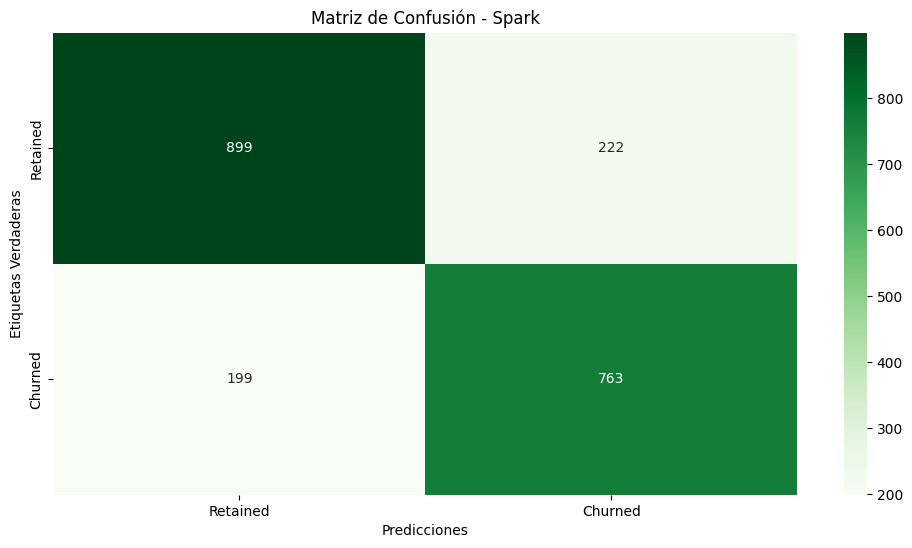

In [ ]:
show_conf_matrix(predictions_rf)

### 4.2.3 AUC ROC y Precision-Recall

In [ ]:
rf_roc, rf_pr = auc_metrics(predictions_rf)


        AUC ROC:  0.8802515203050418

        AUC Precision-Recall: 0.8470215912002105


### 4.2.4 Conclusiones finales

En modelo de **Random Forest de Spark nos muestra un mejor equilibrio entre las métricas**. Esto hace que el **F1 Score** ponderado entre dentro del rango del punto de **Trade Off**.

También hay una **mejora sustancial en el valor de las AUC de las curvas ROC y Precision-Recall**.

## 4.3 GBTClassifier

### 4.3.1 Entrenamiento y feature_importance

In [ ]:
# Entrenamos el modelo y obtenemos predicciones
model_gbt, predictions_gbt = train_model(gbt_model, train_df, test_df)

In [ ]:
# Obtenemos las métricas de Precision, Recall y F1-Score
metrics_gbt = get_metrics(predictions_gbt)


        Precision Retained: 0.83

        Precision Churned: 0.77

        Recall Retained: 0.79

        Recall Churned: 0.81

        F1 Score: 0.80


In [ ]:
# Mostramos en orden las features más importantes
importance_features(model_gbt, feature_columns)

Feature más importantes:
Tenure Months: 0.1326
Monthly Charges: 0.1045
Payment Method_Electronic check: 0.0927
Contract_Two year: 0.0723
Dependents: 0.0650
Total Charges: 0.0623
Contract_One year: 0.0519
Online Security_Yes: 0.0500
Internet Service_No: 0.0467
Phone Service: 0.0375


### 4.3.2 Matriz de confusión

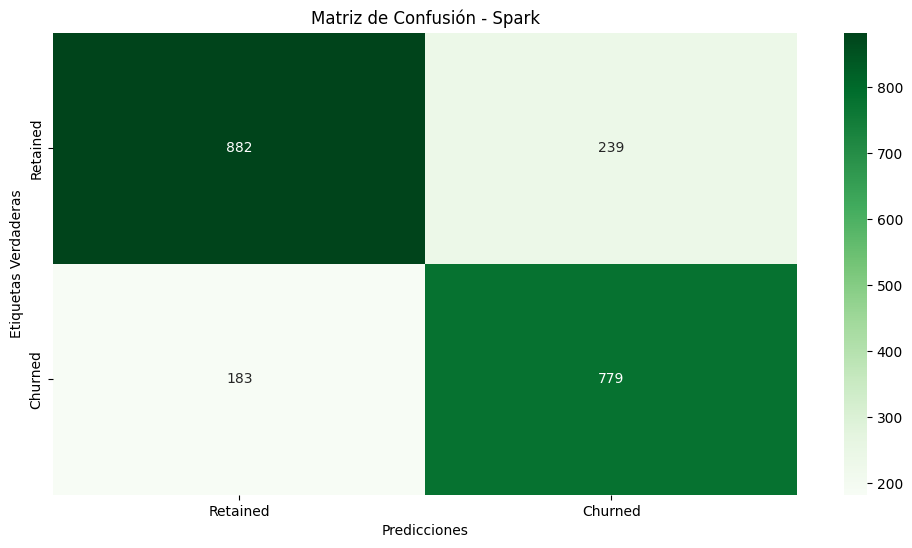

In [ ]:
show_conf_matrix(predictions_gbt)

### 4.3.3 AUC ROC y Precision-Recall

In [ ]:
gbt_roc, gbt_pr = auc_metrics(predictions_gbt)


        AUC ROC:  0.8826560039762515

        AUC Precision-Recall: 0.850052101009534


### 4.3.4 Conclusiones finales

Los valores de las métricas del modelo **GBT Classifier** de Spark son muy similares a las obtenidas con el Random Forest. Hay una **mejora del Recall de la clase minoritaria** a costa de una bajada mínima del Recall de la mayoritaria, pero teniendo en cuenta que nos interesa más el valor de la clase Churned, es una mejora.

## 4.4 Comparativa modelos

In [ ]:
# Establecemos los modelos que queremos comparar
predictions = [predictions_dt, predictions_rf, predictions_gbt]
models = ['Decision Tree', 'Random Forest', 'GBT']
auc_roc = [dt_roc, rf_roc, gbt_roc]
auc_pr = [dt_pr, rf_pr, gbt_pr]
metrics = [metrics_dt, metrics_rf, metrics_gbt]

In [ ]:
def process_metrics(metrics_list):
    # Convertimos una lista de diccionarios en un diccionario con listas
    return {key: [m[key][0] for m in metrics_list] for key in metrics_list[0]}

In [ ]:
# Obtenemos las métricas procesadas para los gráficos
metrics_processed = process_metrics(metrics)

In [ ]:
# Creamos los gráficos para cada una de las métricas
def show_metrics(metrics, models, auc_roc, auc_pr):

    width = 0.35
    x = np.arange(len(models))
    fig, axes = plt.subplots(2, 3, figsize=(32, 12))

    # Precisión
    bars1 = axes[0, 0].bar(x - width/2, metrics['precision_majority'], width, label='Retained')
    bars2 = axes[0, 0].bar(x + width/2, metrics['precision_minority'], width, label='Churned')
    axes[0, 0].set_title('Precisión')
    axes[0, 0].set_ylabel('Precisión')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models)
    axes[0, 0].legend()

    # Recall
    bars3 = axes[0, 1].bar(x - width/2, metrics['recall_majority'], width, label='Retained')
    bars4 = axes[0, 1].bar(x + width/2, metrics['recall_minority'], width, label='Churned')
    axes[0, 1].set_title('Recall')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(models)
    axes[0, 1].legend()

    # F1-Score
    bars5 = axes[0, 2].bar(models, metrics['f1_score'])
    axes[0, 2].set_title('F1-Score ponderado')
    axes[0, 2].set_ylabel('F1-Score')

    # AUC ROC
    bars6 = axes[1, 0].bar(models, auc_roc, color='orange')
    axes[1, 0].set_title('AUC ROC')
    axes[1, 0].set_ylabel('AUC ROC')

    # AUC Precision-Recall
    bars7 = axes[1, 1].bar(models, auc_pr, color='green')
    axes[1, 1].set_title('AUC Precision-Recall')
    axes[1, 1].set_ylabel('AUC Precision-Recall')

    plt.tight_layout()
    plt.show()

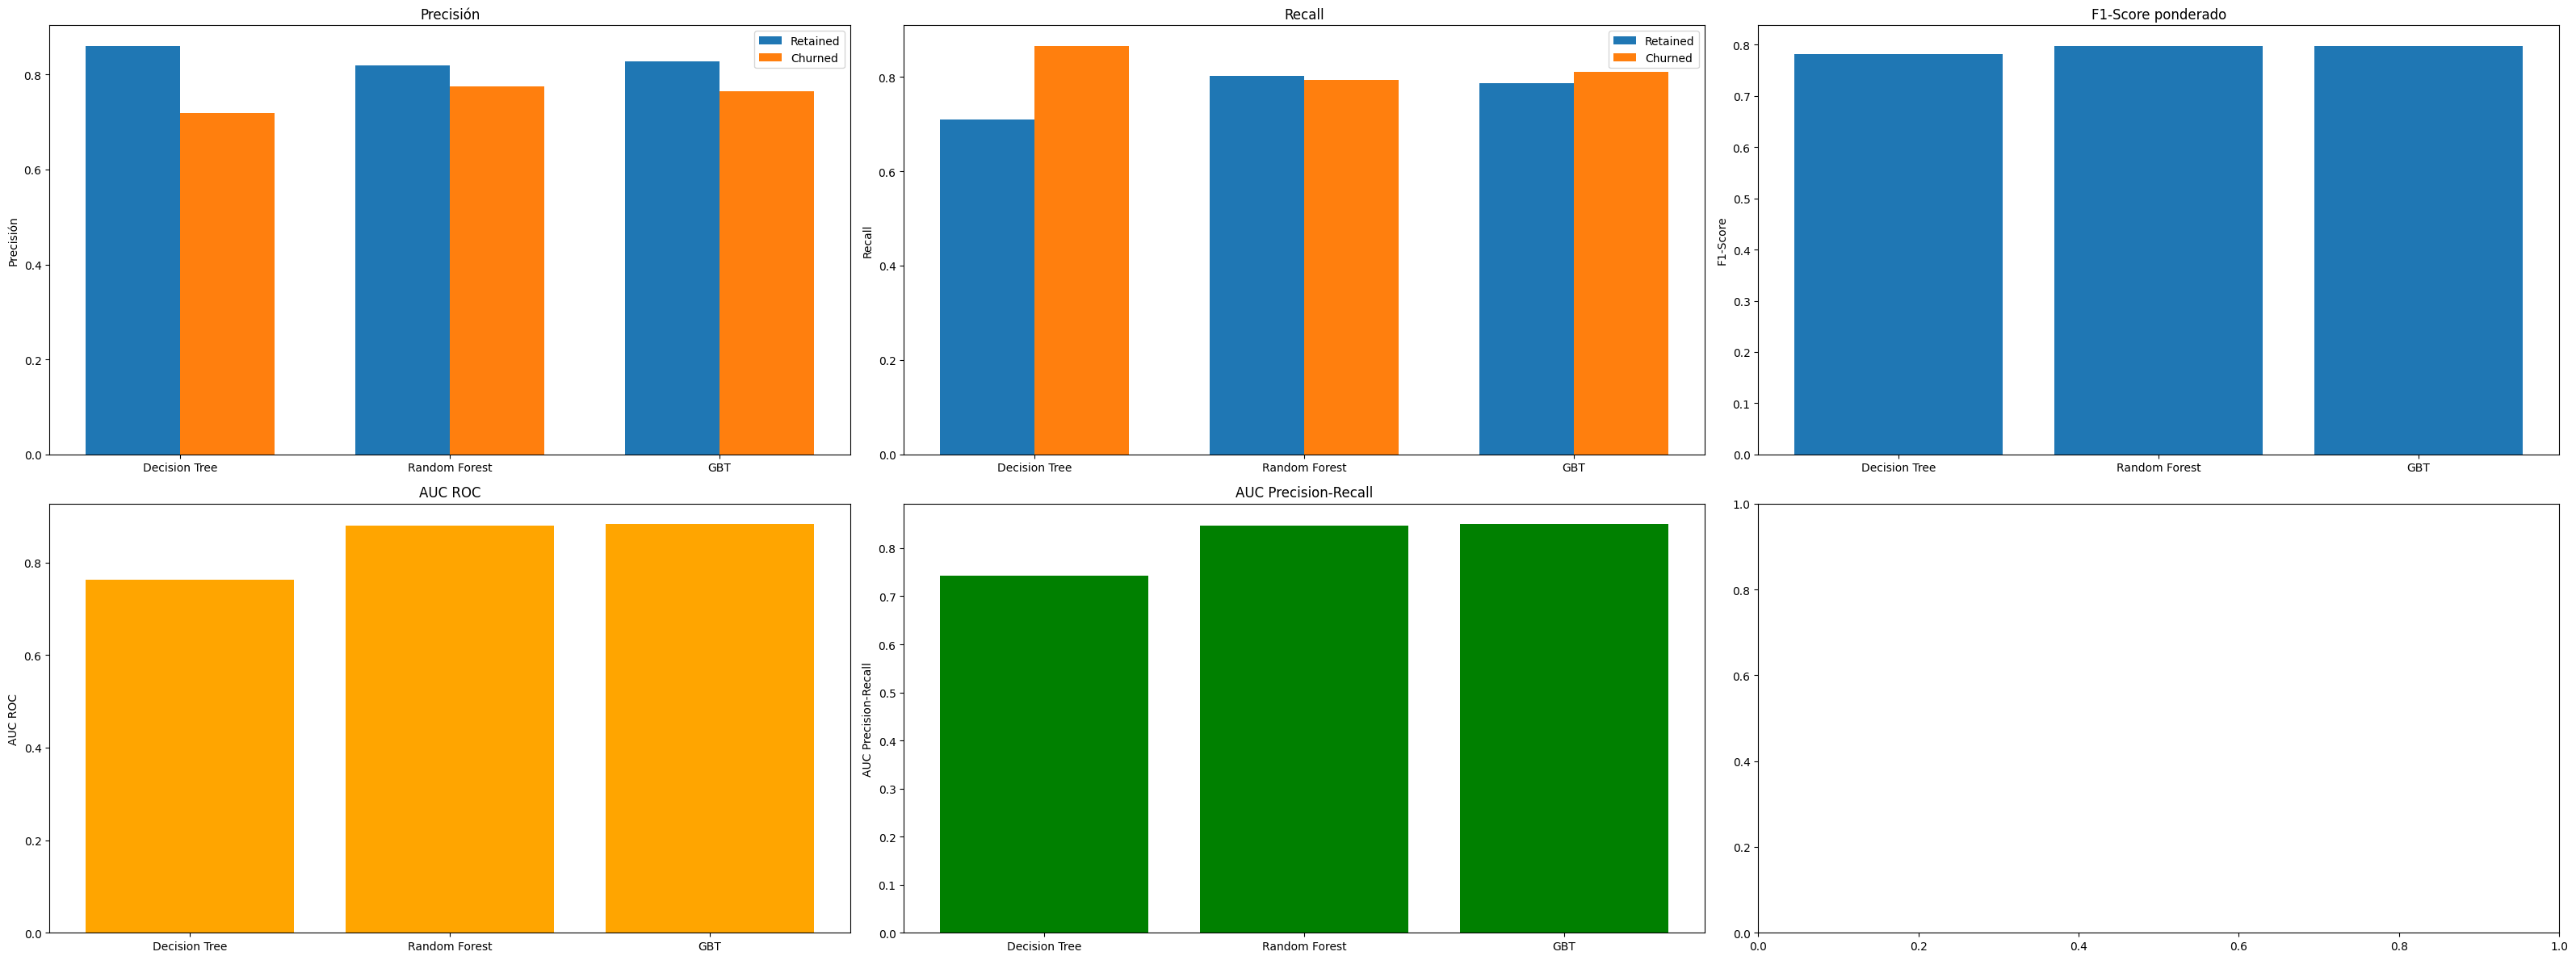

In [ ]:
show_metrics(metrics_processed, models, auc_roc, auc_pr)

Nos quedamos con el modelo GBT Classifier para buscar hiperparámetros que entrenen el mejor modelo posible entre nuestras opciones por esa pequeña mejora en el Recall de la clase minoritaria.

# 5 Fine Tuning

Usando Cross Validation, buscamos encontrar la mejor combinación de hiperparámetros para mejorar la efectividad del modelo de GBT Classifier.

## 5.1 Entrenamiento y feature_importance

In [ ]:
gbt_t = GBTClassifier(labelCol='indexedLabel', featuresCol='features')

paramGrid = ParamGridBuilder().addGrid(gbt_t.maxDepth, [5, 10]) \
                              .addGrid(gbt_t.maxIter, [10, 20]) \
                              .addGrid(gbt_t.minInstancesPerNode, [1, 5]) \
                              .addGrid(gbt_t.maxBins, [8, 16])\
                              .addGrid(gbt_t.minInfoGain, [0.0,0.01]) \
                              .addGrid(gbt_t.subsamplingRate, [0.9, 0.95])\
                              .build()

crossval = CrossValidator(estimator=gbt_t,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='indexedLabel', metricName='areaUnderPR'),
                          numFolds=2)

# Lanzamos la validación cruzada - Sería el relativo al Grid Search
cvModel = crossval.fit(train_df)

bestModel = cvModel.bestModel
predictions_gbt_t = bestModel.transform(test_df)
bestParams = bestModel.extractParamMap()

print('Best Parameters:')
for param, value in bestParams.items():
    print(f'{param.name}: {value}')

Best Parameters:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: indexedLabel
leafCol: 
lossType: logistic
maxBins: 8
maxDepth: 5
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 5
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 1875596035120046507
stepSize: 0.1
subsamplingRate: 0.9
validationTol: 0.01


In [ ]:
# Obtenemos las métricas de Precision, Recall y F1-Score
metrics_gbt_t = get_metrics(predictions_gbt_t)


        Precision Retained: 0.84

        Precision Churned: 0.77

        Recall Retained: 0.79

        Recall Churned: 0.82

        F1 Score: 0.80


In [ ]:
# Mostramos en orden las features más importantes
importance_features(bestModel, feature_columns)

Feature más importantes:
Tenure Months: 0.1671
Monthly Charges: 0.0902
Payment Method_Electronic check: 0.0821
Contract_Two year: 0.0762
Dependents: 0.0624
Internet Service_No: 0.0607
Contract_One year: 0.0589
Total Charges: 0.0575
Online Security_Yes: 0.0465
Tech Support_Yes: 0.0397


## 5.2 Matriz de confusión

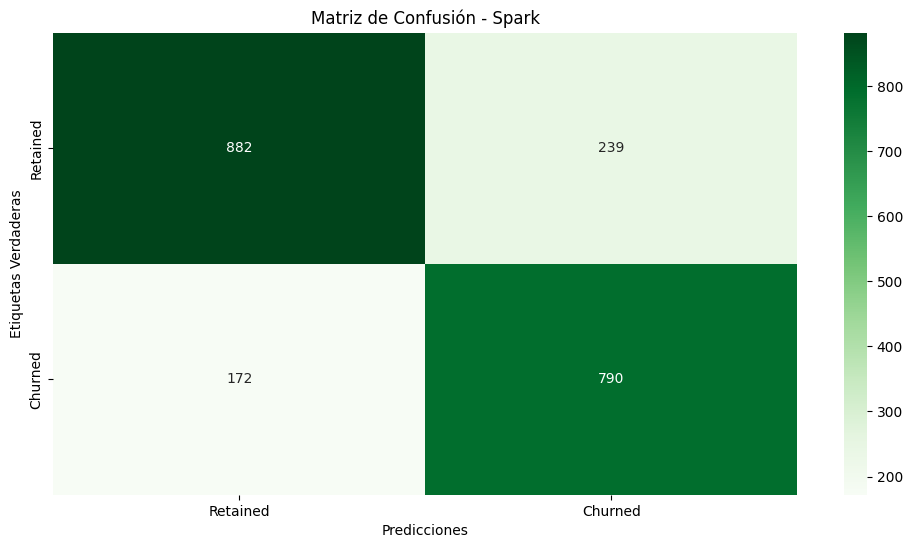

In [ ]:
show_conf_matrix(predictions_gbt_t)

## 5.3 AUC ROC y Precision-Recall

In [ ]:
gbt_t_roc, gbt_t_pr = auc_metrics(predictions_gbt)


        AUC ROC:  0.882656003976253

        AUC Precision-Recall: 0.8500521010095341


## 5.4 Comparativa de modelos

En esta sección compararemos las métricas del modelo GBT antes y después del fine-tuning

In [ ]:
# Establecemos los modelos que queremos comparar
predictions_t = [predictions_gbt, predictions_gbt_t]
models_t = ['GBT','GBT Fine Tuned']
auc_roc_t = [gbt_roc, gbt_t_roc]
auc_pr_t = [gbt_pr, gbt_t_pr]
metrics_t = [metrics_gbt, metrics_gbt_t]
metrics_processed_t = process_metrics(metrics_t)

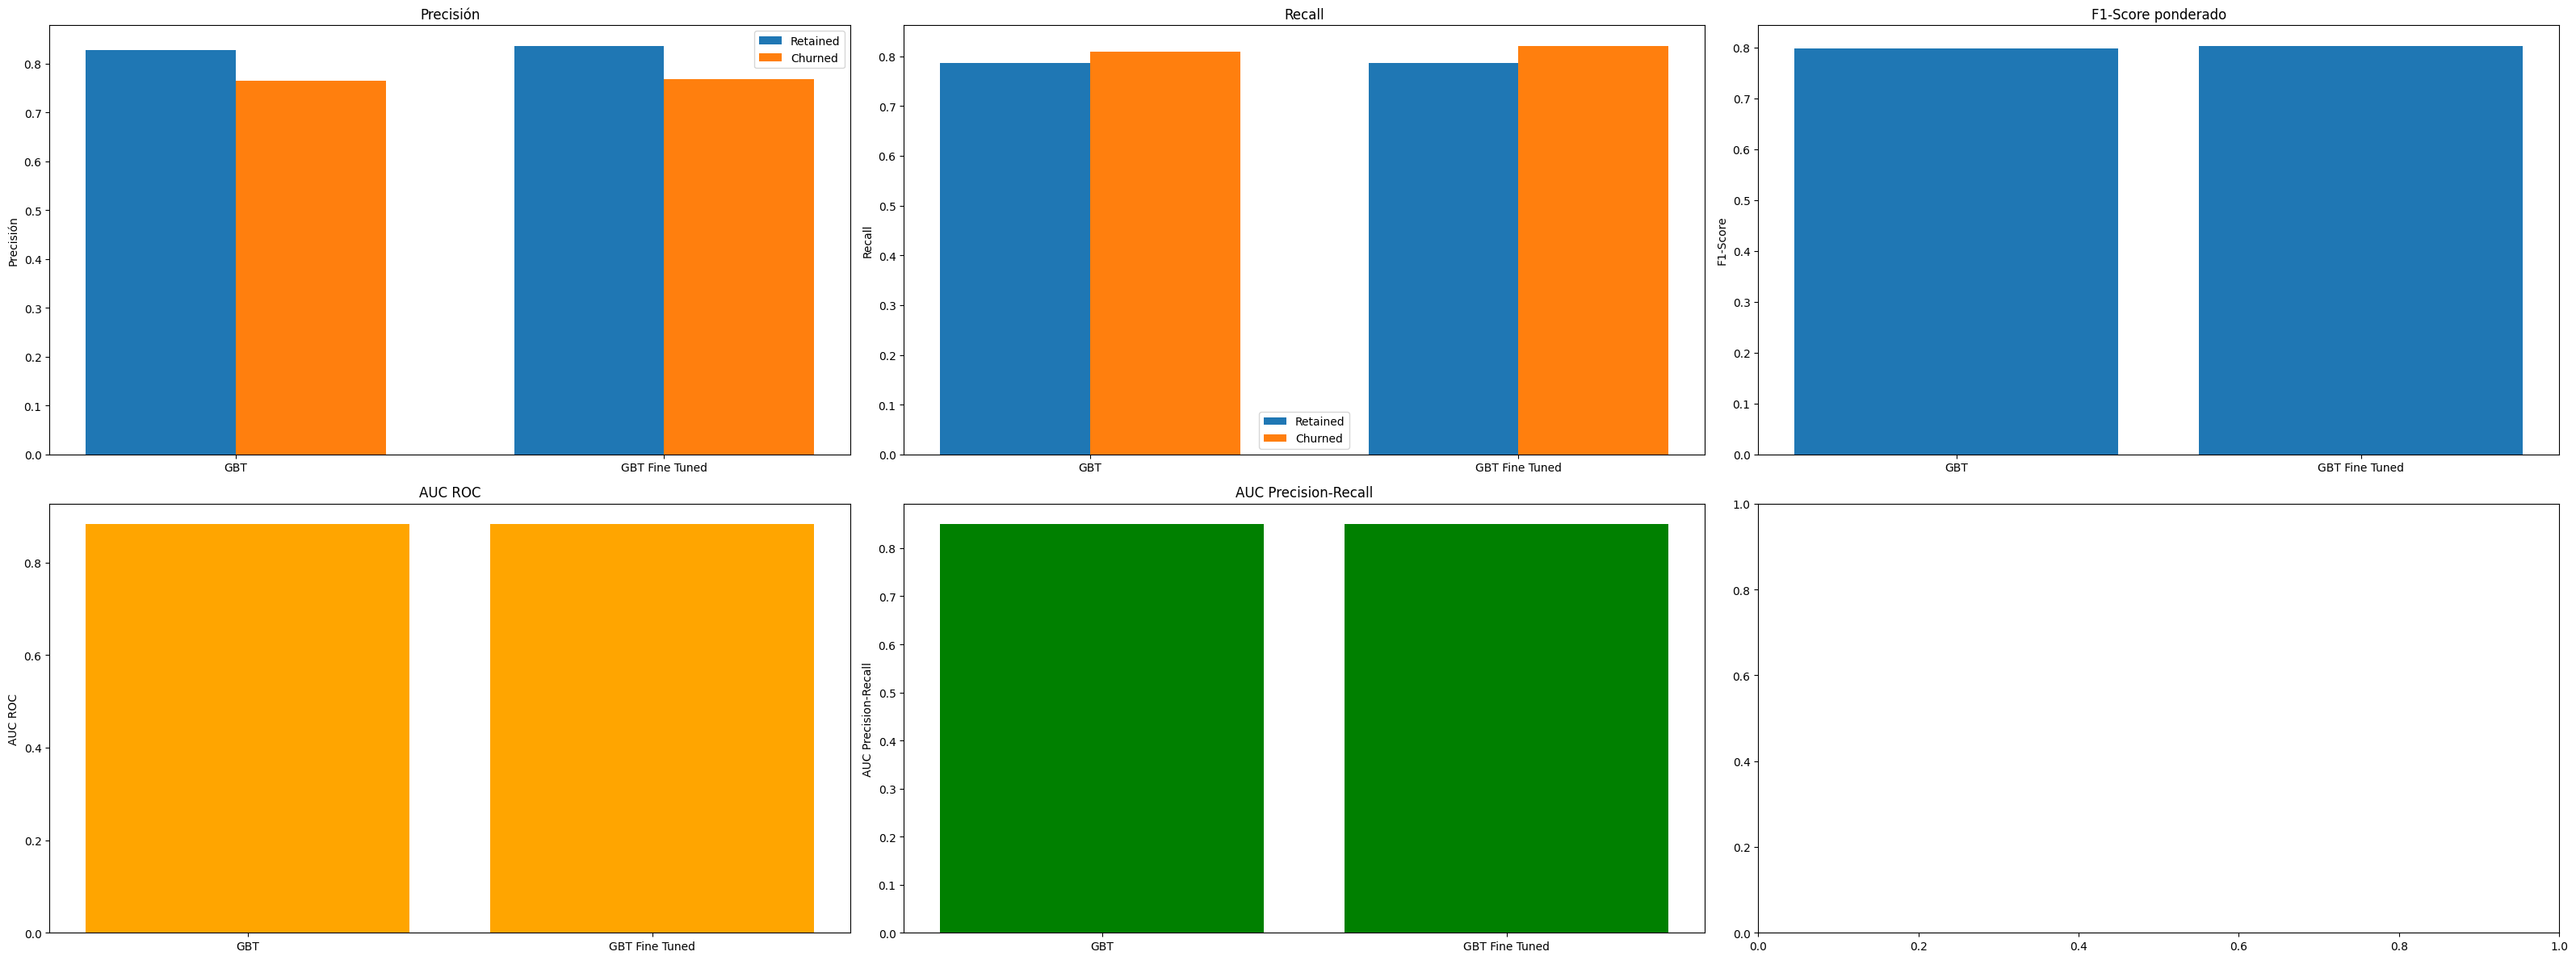

In [ ]:
show_metrics(metrics_processed_t, models_t, auc_roc_t, auc_pr_t)

## 5.4 Conclusiones finales

A pesar de ser solo una **pequeña mejora en el  Recall de la clase minoritaria y la Precisión de la clase Retained**, obtenemos un modelo algo superior después de aplicar fine tuning sobre este.

# 6. Exportación del mejor modelo

In [ ]:
# Guardar el modelo en la sesión de Colab
model_path = "/content/best_spark_model"
bestModel.save(model_path)

In [ ]:
import shutil
from google.colab import files

In [ ]:
# Comprimir el modelo en un archivo ZIP
shutil.make_archive(model_path, 'zip', model_path)

# Descargar el archivo ZIP
files.download(model_path + ".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>